In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
from IPython.display import clear_output

import os
import sys
import time
import gc
import json
import glob
import ast

import shutil
import joblib
import itertools

import utils

import numpy as np
import pandas as pd
# config to not reduce column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

import seaborn as sns
plt.style.use('seaborn-whitegrid')

import plotly as ply
import plotly.express as px

from itertools import permutations, combinations

from tabulate import tabulate

import pickle
from joblib import dump, load


import sklearn
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier


from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.over_sampling  import SMOTE


import shap
shap.initjs()

import interpret

from collections import Counter


# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('always')

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline  



### Get Training, Validation, Balanced sets 

##### NOTE: the "training_sets" contains the sets of training and validation to help the models execution, with the following information:
 - `Dataset Info `  ["Training", "Training Balanced"]
 - `Features Info`  ["All Features", "Feature Selection"]
 - `"X" to train`   
 - `"y" to train` 
 - `"X" to validation`


In [2]:
X_train, X_train_fs, y_train, \
X_train_balanced, X_train_fs_balanced, y_train_balanced,\
X_valid, X_valid_fs, y_valid, training_sets = utils.get_train_and_validation_data(
    return_training_sets=True
)


X_all = pd.concat([X_train, X_valid])
X_all_fs = pd.concat([X_train_fs, X_valid_fs])
y_all = np.concatenate((y_train, y_valid))


display(X_train)


,Diagnosis_Delay,Age_Range_at_Onset,Riluzole,Sex_Male,Site_Onset,FVC,BMI,Q1_Speech_slope,Q2_Salivation_slope,Q3_Swallowing_slope,Q4_Handwriting_slope,Q5_Cutting_slope,Q6_Dressing_and_Hygiene_slope,Q7_Turning_in_Bed_slope,Q8_Walking_slope,Q9_Climbing_Stairs_slope,Q10_Respiratory_slope,Qty_Regions_Involved,Region_Involved_Bulbar,Region_Involved_Upper_Limb,Region_Involved_Lower_Limb,Region_Involved_Respiratory,Patient_with_Gastrostomy
0,1.0,0.50,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75,1.0,1.0,1.0,0.0,0.0
1,0.5,0.75,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.0,0.75,1.0,1.0,1.0,0.0,0.0
2,1.0,0.25,0.0,1.0,1.0,0.0,0.50,0.5,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.0,0.75,1.0,1.0,1.0,0.0,0.0
3,0.5,0.50,0.0,0.0,0.0,1.0,1.00,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.5,0.5,0.5,0.75,1.0,0.0,1.0,1.0,0.0
4,0.0,0.75,0.0,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,0.5,0.50,0.0,0.0,0.0,1.0,0.50,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.00,1.0,1.0,1.0,1.0,1.0
1569,0.5,0.50,0.0,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.0,0.0
1570,1.0,0.50,0.0,1.0,1.0,0.0,1.00,0.5,0.0,0.0,0.0,1.0,1.0,0.5,0.0,0.0,1.0,0.75,1.0,1.0,0.0,1.0,0.0
1571,1.0,0.75,1.0,1.0,1.0,1.0,0.50,0.0,0.0,0.5,0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.00,1.0,1.0,1.0,1.0,0.0


---
# Create the best model for each scenario

 - ## `Single-Model`: $SVM$
 - ## `Ensemble-Imbalance`: $BalancedBagging$ with $NN$

In [5]:
single_model, ensemble_imbalance = utils.get_best_models_by_scenario()

print(single_model, '\n', ensemble_imbalance)


SVC(C=3, class_weight='balanced', gamma='auto', probability=True,
    random_state=42) 
 BalancedBaggingClassifier(estimator=MLPClassifier(alpha=0.05,
                                                  hidden_layer_sizes=(14,),
                                                  learning_rate_init=0.7,
                                                  max_iter=1000,
                                                  random_state=42,
                                                  solver='sgd'),
                          n_estimators=50, random_state=42,
                          sampling_strategy='all')


---
# Train the models using the $Training$ set 

In [8]:
single_model = single_model.fit(X=X_train, y=y_train)
ensemble_imbalance = ensemble_imbalance.fit(X=X_train, y=y_train)

---
# Make predictions using the Validation set

In [9]:
y_pred_single = single_model.predict(X=X_valid)
y_pred_ens_imb = ensemble_imbalance.predict(X=X_valid)

models_results = []

for i, y_pred in enumerate([y_pred_single, y_pred_ens_imb]):
    #get performance
    bal_acc, sens, spec, auc, acc, prec, f1 = utils.get_scores_from_predict(
        y_validation=y_valid, 
        y_pred=y_pred, 
    )

    # Store the Validation and Training performances
    performance_to_save = {
        'Scenario': ('Single-Model' if i == 0 else 'Ensemble-Imbalance'),
        'Model': ('SVM' if i == 0 else 'Balanced Bagging (NN)'),
        'Dataset': 'Imbalanced',
        'Features': 'All Features',
        # Validation performance
        'Valid_BalAcc': bal_acc,
        'Valid_Sens'  : sens,
        'Valid_Spec'  : spec,
    }
    #
    models_results.append(performance_to_save)

    
df_results = pd.DataFrame(models_results)
df_results.sort_values(by=['Scenario', 'Features'], ascending=True, inplace=True)
df_results


,Scenario,Model,Dataset,Features,Valid_BalAcc,Valid_Sens,Valid_Spec
1,Ensemble-Imbalance,Balanced Bagging (NN),Imbalanced,All Features,0.88,0.94,0.82
0,Single-Model,SVM,Imbalanced,All Features,0.85,0.89,0.82


---
---
# Perform SHAP to analyze the feature importances

In [19]:
#Get shap values
explainer = shap.KernelExplainer(ensemble_imbalance.predict, X_valid)
shap_values = explainer.shap_values(X_valid)

# explainer = shap.Explainer(ensemble_imbalance.predict, X_valid)
# shap_values = explainer(X_valid)

Using 394 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/394 [00:00<?, ?it/s]

In [20]:
file = 'saved_models/SHAP_Kernel_Explainer_BalBag_NN.model'
with open(file, 'wb') as file:
    pickle.dump(explainer, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(explainer, to_serialize)

#save SHAP Values object
file = 'saved_models/SHAP_Kernel_values_BalBag_NN.model'
with open(file, 'wb') as file:
    pickle.dump(shap_values, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(shap_values, to_serialize)


In [18]:
#Get shap values
explainer_svm = shap.Explainer(svm_fitted.predict, X_train)
shap_values_svm = explainer_svm(X_train)

Permutation explainer: 1574it [19:48,  1.31it/s]                                


In [33]:
file = 'saved_models/SHAP_explainer_SVM.model'
with open(file, 'wb') as file:
    pickle.dump(explainer_svm, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(explainer_svm, to_serialize)

#save SHAP Values object
file = 'saved_models/SHAP_values_SVM.model'
with open(file, 'wb') as file:
    pickle.dump(shap_values_svm, file)
#     pickle.dump(username, file)

# to_serialize = open(file, 'wb') 
# pickle.dump(shap_values_svm, to_serialize)


-------------
Beeswarm plot
-------------


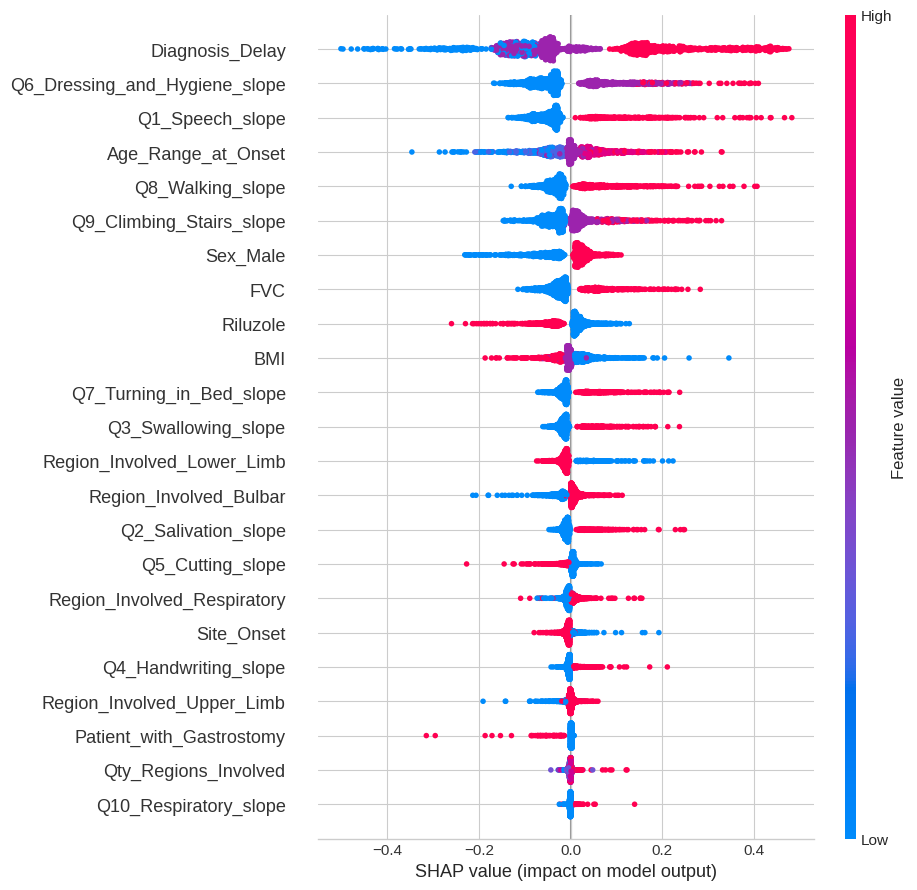

In [30]:
utils.print_string_with_separators('Beeswarm plot')
shap.plots.beeswarm(shap_values_svm, max_display=25)


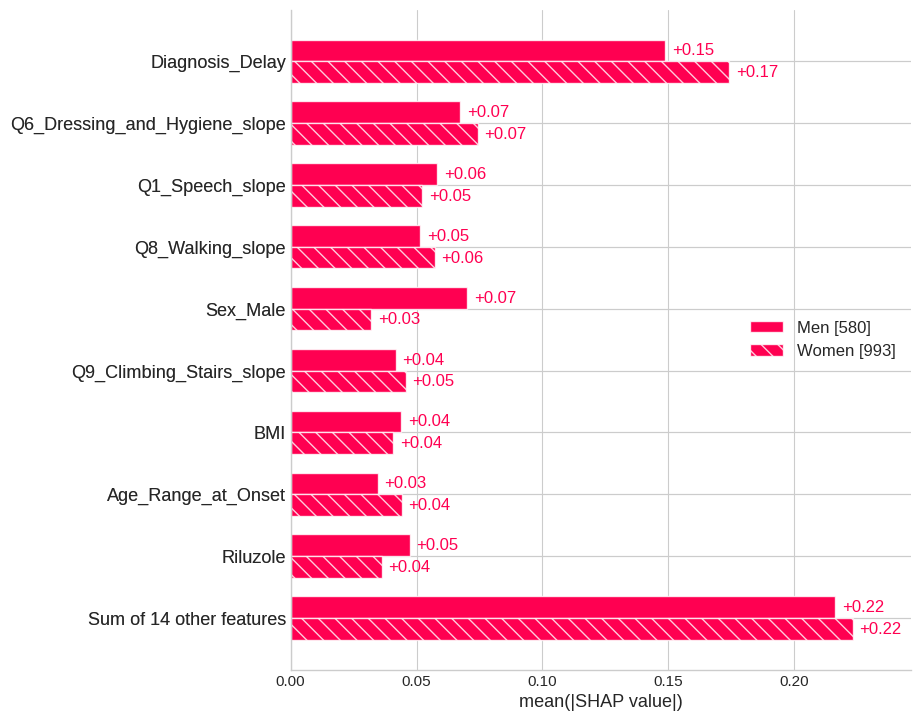

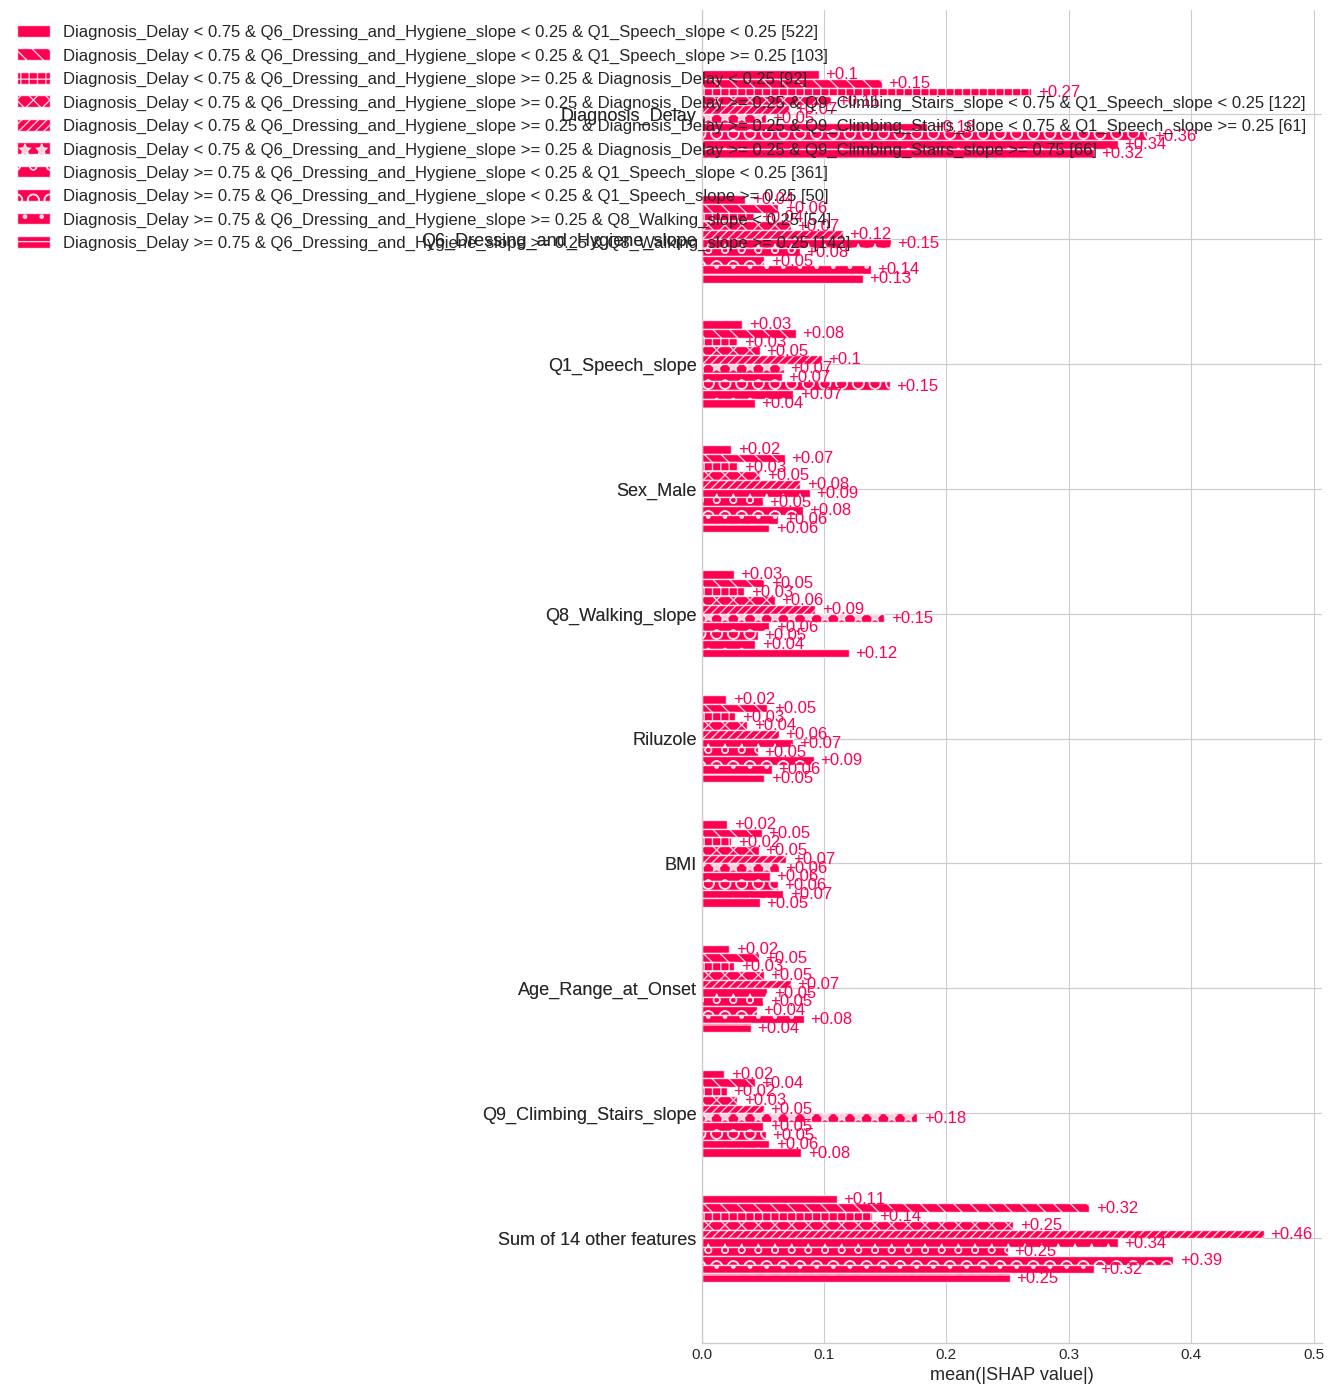

-------------
Beeswarm plot
-------------


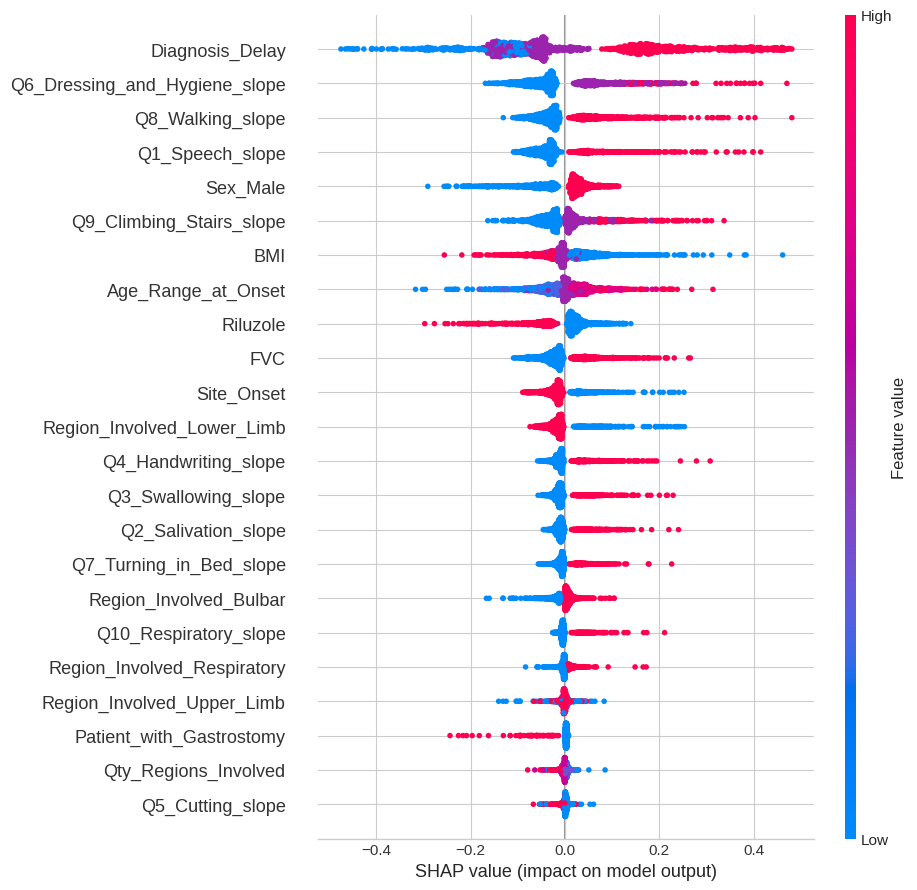

---------
Mean SHAP
---------


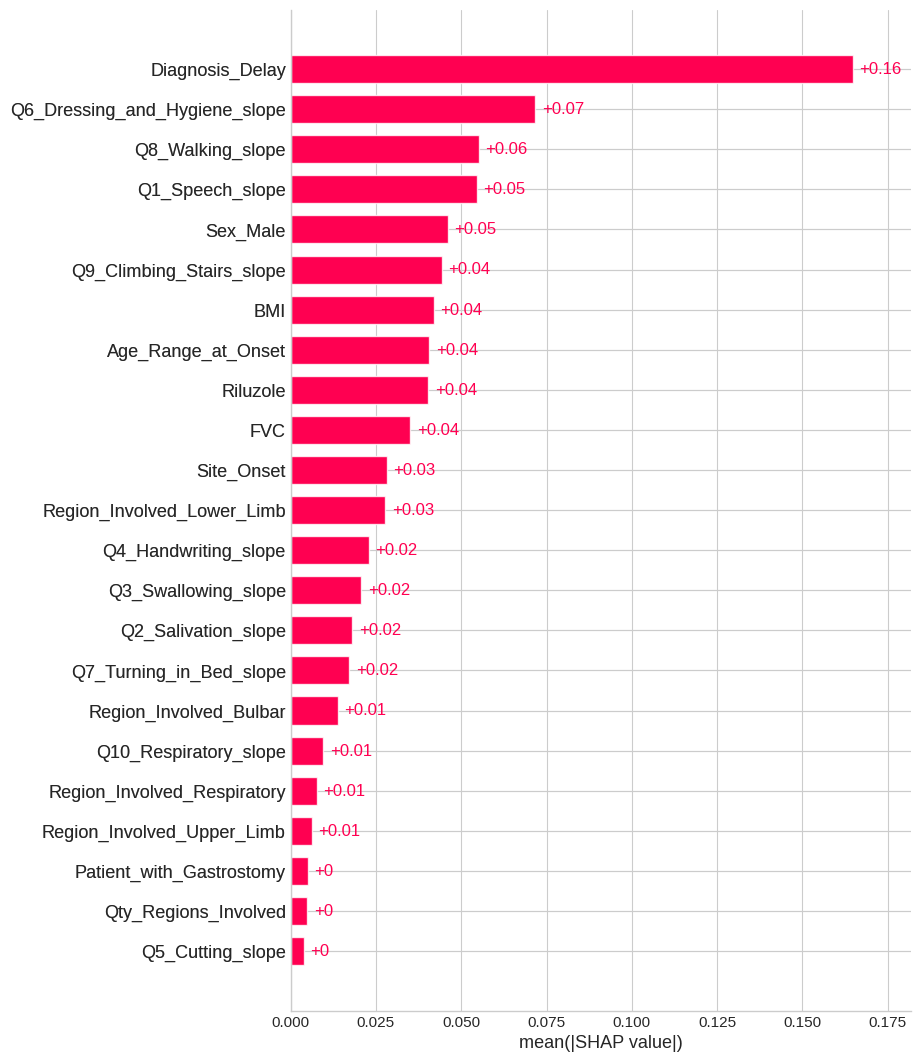

---------
Waterfall
---------


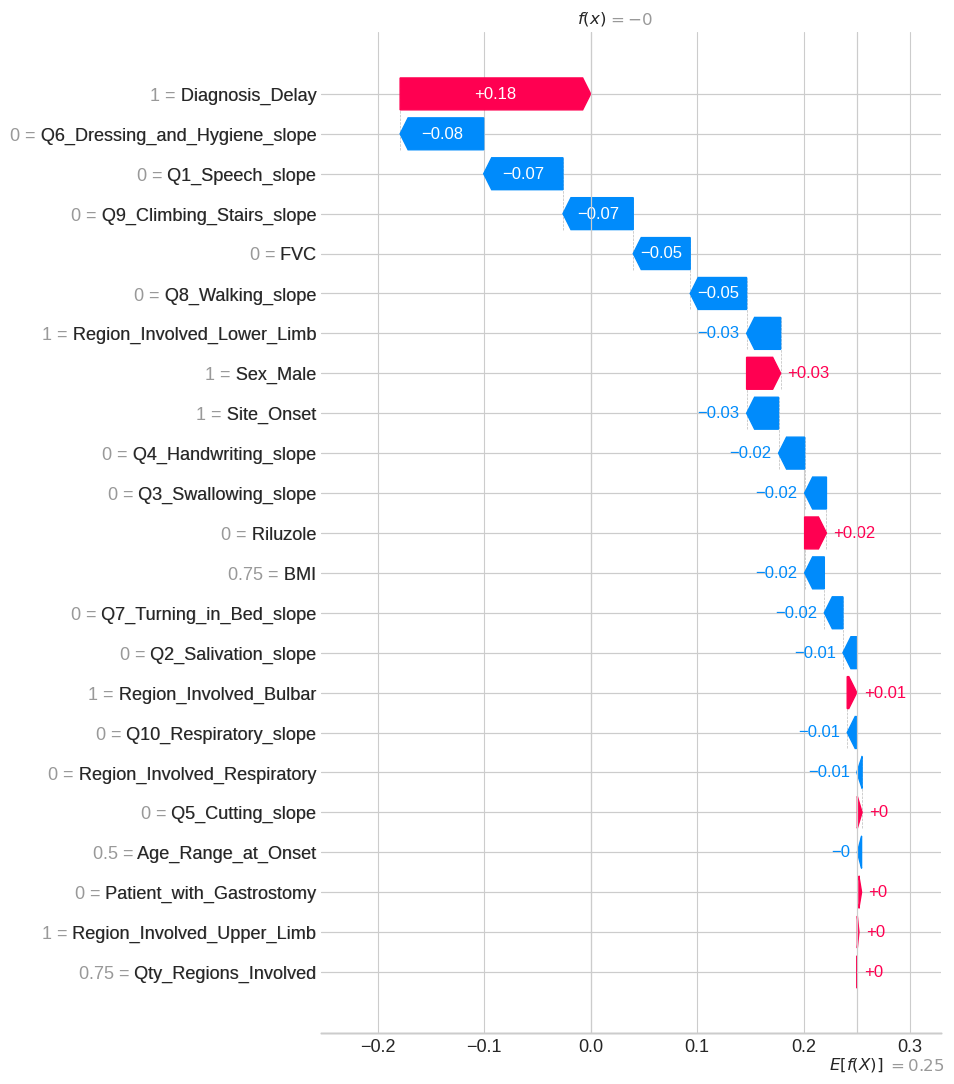

---------
Forceplot
---------
------------------
Stacked force plot
------------------


In [96]:
sex = ["Women" if shap_values[i,"Sex_Male"].data == 1 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

shap.plots.bar(shap_values.cohorts(10).abs.mean(0))

utils.print_string_with_separators('Beeswarm plot')
shap.plots.beeswarm(shap_values, max_display=25)

utils.print_string_with_separators('Mean SHAP')
shap.plots.bar(shap_values, max_display=25)

utils.print_string_with_separators('Waterfall')
shap.plots.waterfall(shap_values[0], max_display=25)

utils.print_string_with_separators('Forceplot')
shap.plots.force(shap_values[0])

utils.print_string_with_separators('Stacked force plot')
shap.plots.force(shap_values[0:500])

# shap.plots.waterfall(shap_values[500])
# shap.plots.waterfall(shap_values[1499])

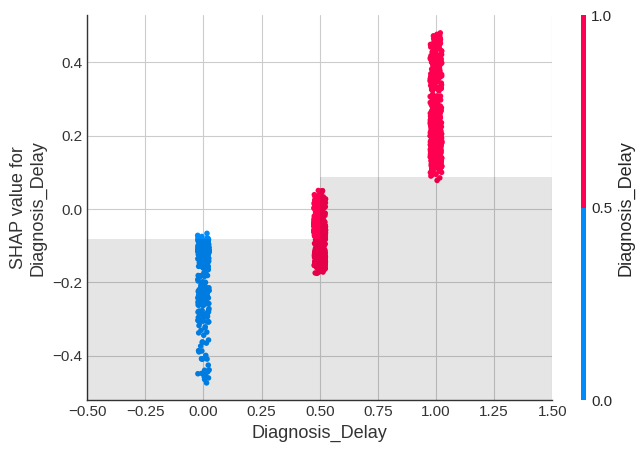

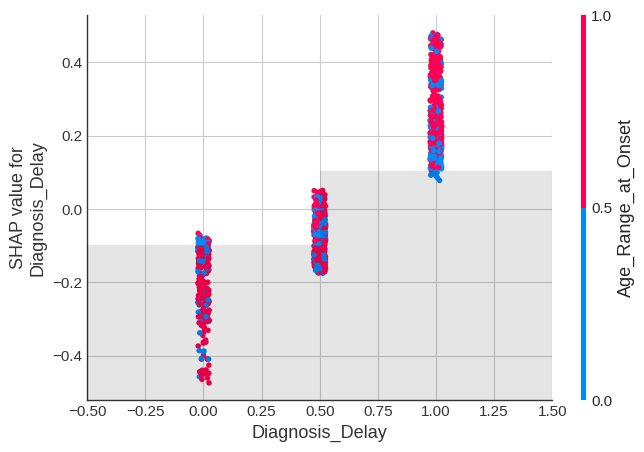

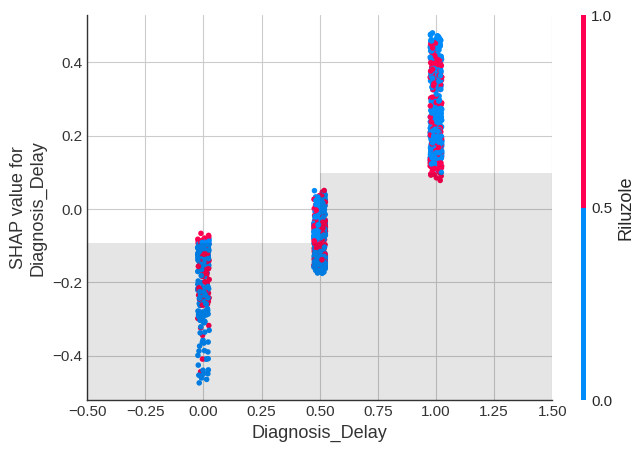

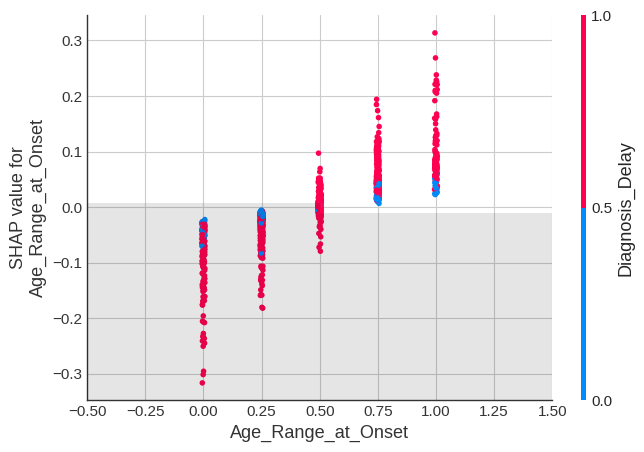

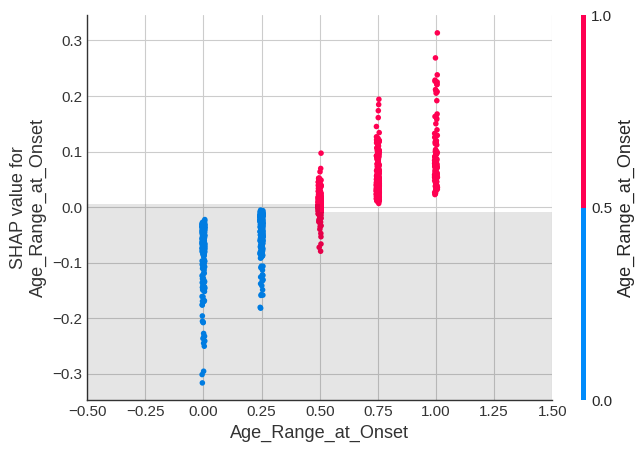

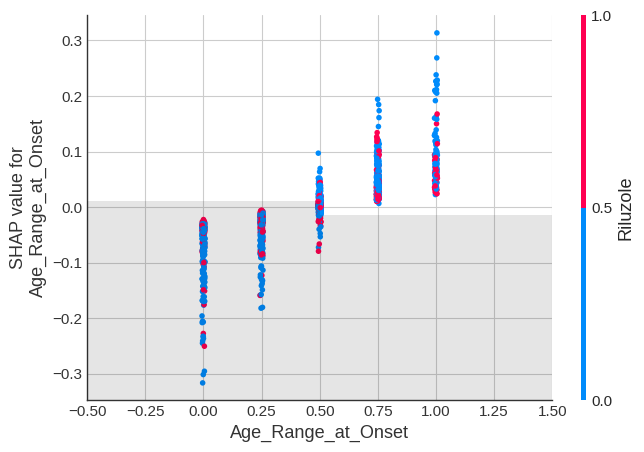

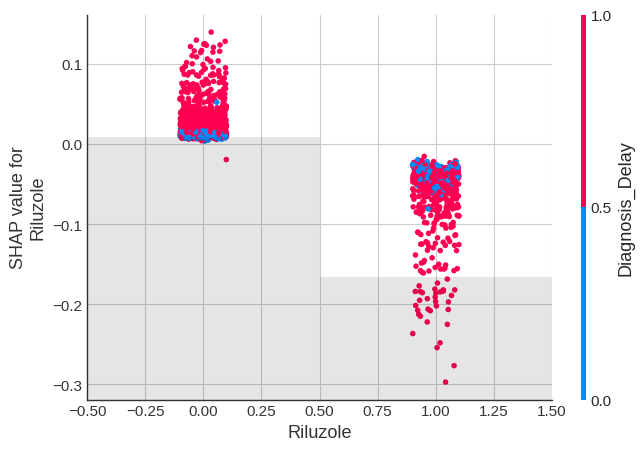

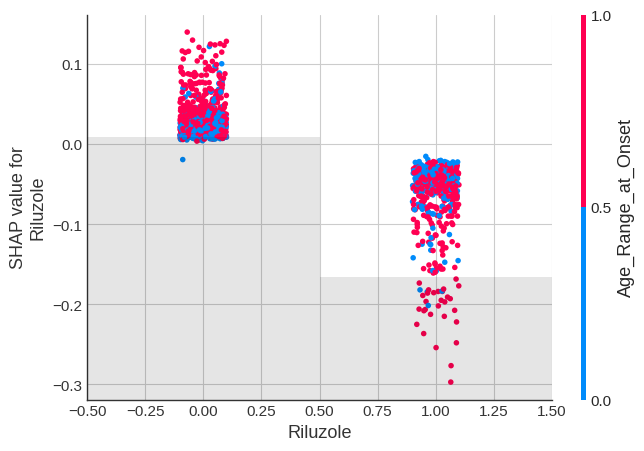

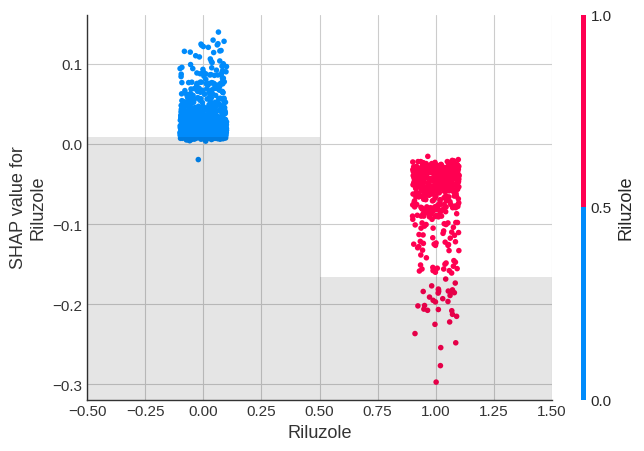

In [93]:
for feat1 in shap_values.feature_names[0:3]:
    for feat2 in shap_values.feature_names[0:3]:
        shap.plots.scatter(
            shap_values[:,feat1],
            color=shap_values[:,feat2]
        )


In [50]:
display(shap_values.feature_names)

['Diagnosis_Delay',
 'Age_Range_at_Onset',
 'Riluzole',
 'Sex_Male',
 'Site_Onset',
 'FVC',
 'BMI',
 'Q1_Speech_slope',
 'Q2_Salivation_slope',
 'Q3_Swallowing_slope',
 'Q4_Handwriting_slope',
 'Q5_Cutting_slope',
 'Q6_Dressing_and_Hygiene_slope',
 'Q7_Turning_in_Bed_slope',
 'Q8_Walking_slope',
 'Q9_Climbing_Stairs_slope',
 'Q10_Respiratory_slope',
 'Qty_Regions_Involved',
 'Region_Involved_Bulbar',
 'Region_Involved_Upper_Limb',
 'Region_Involved_Lower_Limb',
 'Region_Involved_Respiratory',
 'Patient_with_Gastrostomy']

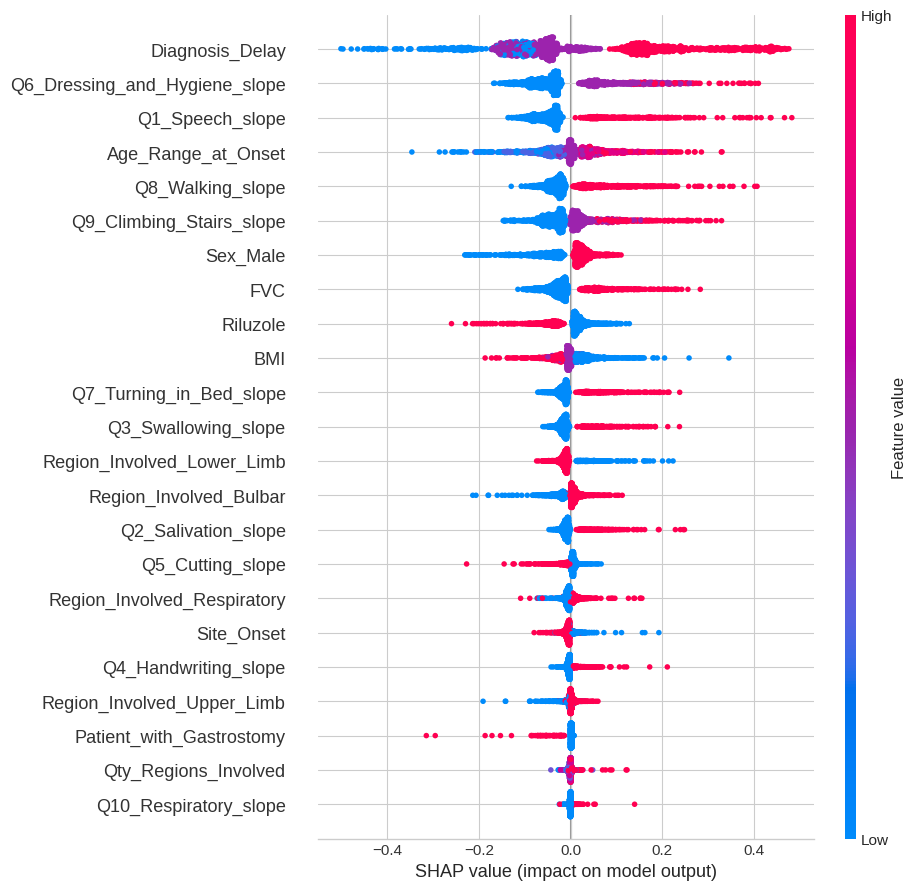

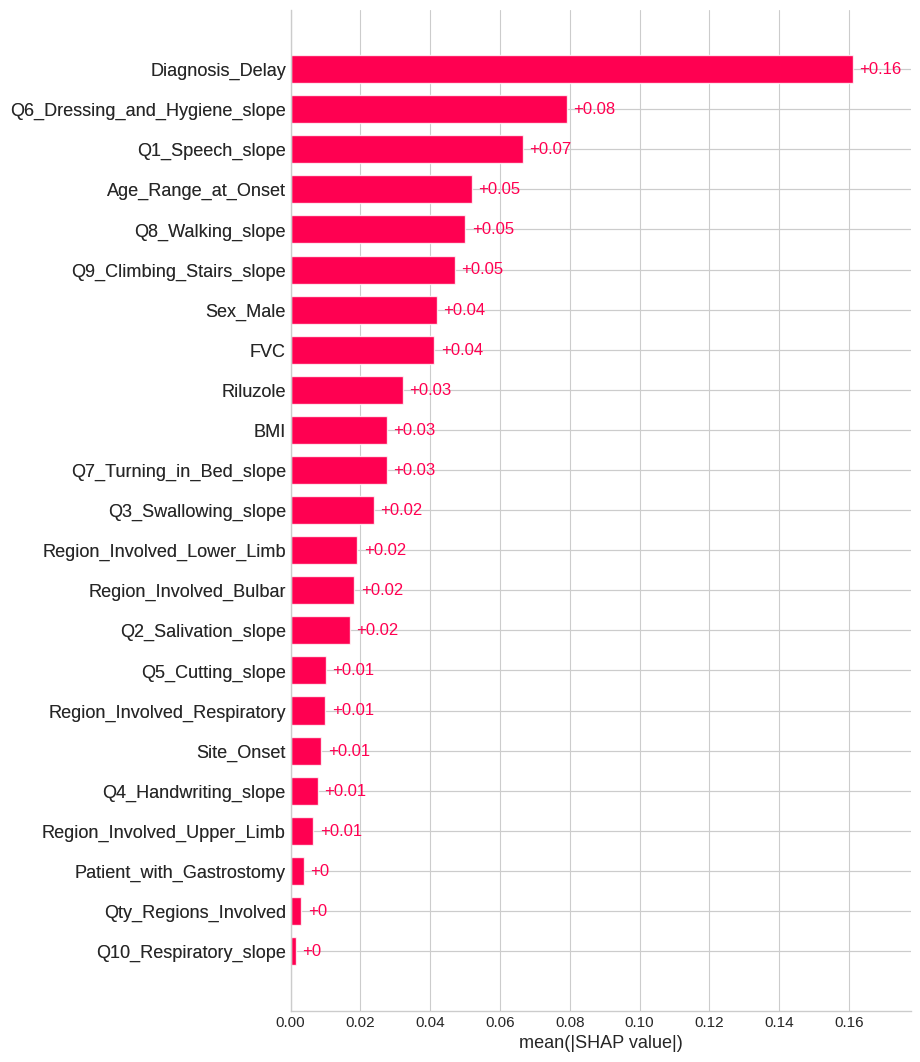

In [40]:

file = 'saved_models/SHAP_values_BalBag_NN.model'
file = 'saved_models/SHAP_values_SVM.model'

# Load all from disk to keep the example short.
with open(file, 'rb') as fl:
    shap_values_loaded = pickle.load(fl)

# display(shap_values_loaded)

# class_count = len(shap_values_loaded.base_values)
# display(class_count)


shap.plots.beeswarm(
    shap_values_loaded, 
    max_display=25
)

shap.plots.bar(
    shap_values_loaded, 
    max_display=25,
)


In [76]:
shap.plots.waterfall(shap_values2[1])

TypeError: 'Permutation' object is not subscriptable

In [73]:
shap_values2.features_names

NameError: name 'shap_values2' is not defined